!git clone https://github.com/Taynguyen4488/ComputerVision.git
%cd ComputerVision


Project 1: BIỂU DIỄN ẢNH MÀU VÀ LỌC TÍN HIỆU


# Setup

In [2]:
!pip install opencv-python matplotlib numpy

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
time.sleep(0.1)
%matplotlib inline

# Sample image


Đang xử lý: image1.jpg


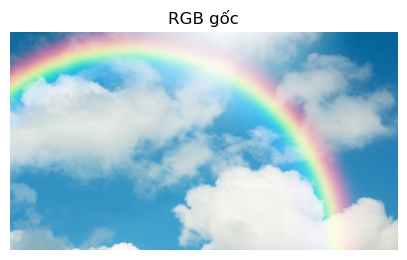


Đang xử lý: image2.jpg


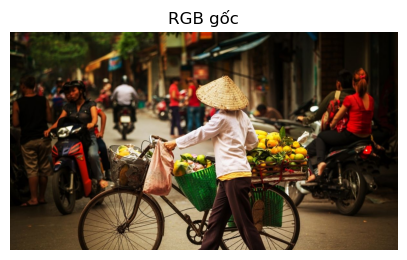

In [4]:
image_paths = ["image1.jpg", "image2.jpg"]
def show_group(title_list, img_list, cmap_list=None):
    n = len(img_list)
    plt.figure(figsize=(15,5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        if cmap_list and cmap_list[i]:
            plt.imshow(img_list[i], cmap=cmap_list[i])
        else:
            plt.imshow(img_list[i])
        plt.title(title_list[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
def show(title, img, cmap=None):
    plt.figure(figsize=(5,5))
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

for path in image_paths:
    if not os.path.exists(path):
        print(f"Không tìm thấy {path}")
        continue

    print(f"\nĐang xử lý: {path}")
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    show("RGB gốc", img_rgb)

# PHẦN 1: BIỂU DIỄN ẢNH MÀU VÀ ẢNH XÁM

# Tách kênh


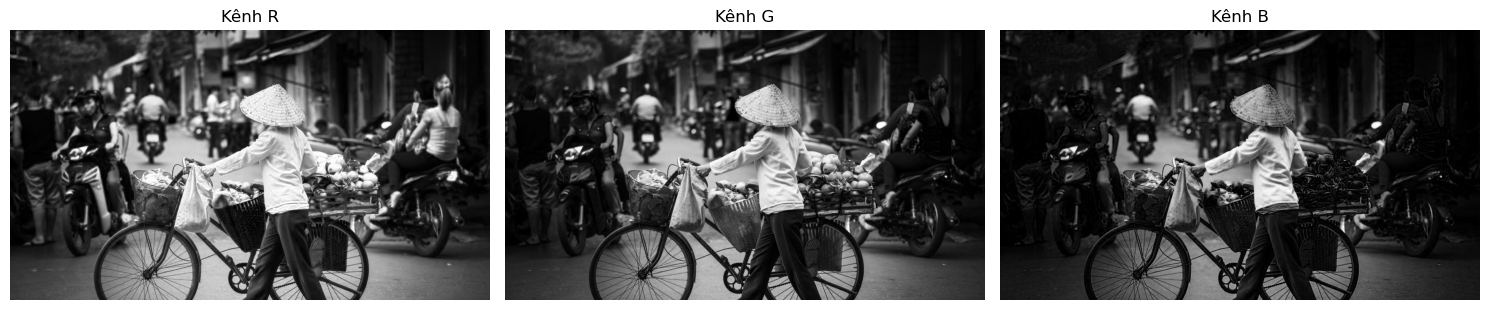

In [5]:
R, G, B = img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]
show_group(
        ["Kênh R", "Kênh G", "Kênh B"],
        [R, G, B],
        ["gray", "gray", "gray"]
    )

# Chuyển ảnh xám bằng 3 thuật toán

# Dùng thuật toán ẩn trong Opencv

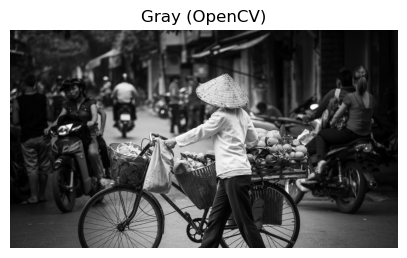

In [6]:
gray_cv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
show("Gray (OpenCV)", gray_cv, 'gray')


# Dùng công thức Chuẩn
Gray = (0.299 * R + 0.587 + G + 0.114 * B)

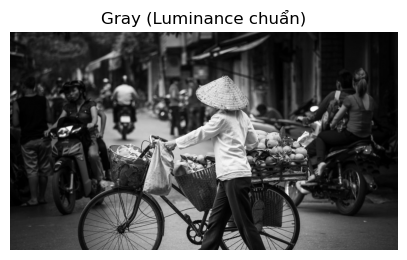

In [7]:
gray_luminance = (
        0.299 * R +
        0.587 * G +
        0.114 * B
    ).astype(np.uint8)
show("Gray (Luminance chuẩn)", gray_luminance, 'gray')

# Dùng công thức chia trung bình 3 kênh
Y = (R + G + B) / 3

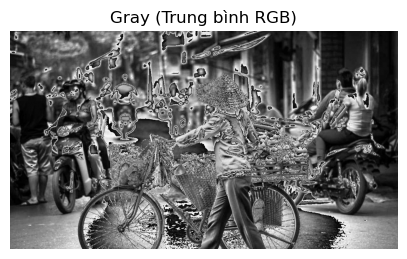

In [8]:
gray_average = ((R + G + B) / 3).astype(np.uint8)
show("Gray (Trung bình RGB)", gray_average, 'gray')

# Tái tạo lại kênh màu

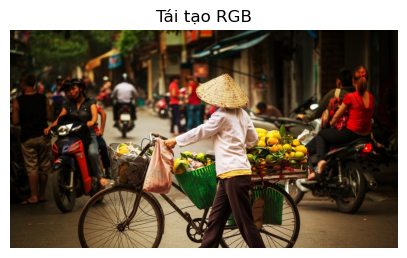

In [9]:
gray_to_rgb = cv2.cvtColor(gray_cv, cv2.COLOR_GRAY2RGB)
reconstructed = np.stack((R, G, B), axis=2)
show("Tái tạo RGB", reconstructed)

# Hoán đổi kênh
swap (R, G, B) Thành (B, R, G)

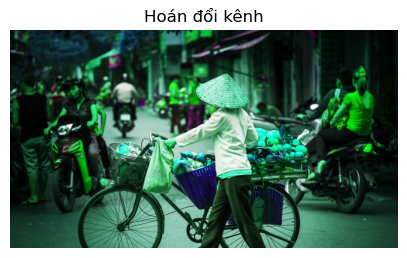

In [10]:
swap = np.stack((B, R, G), axis=2)
show("Hoán đổi kênh", swap)

Phần 2: LỌC ẢNH VỚI LOW-PASS VÀ HIGH-PASS FILTER

# Low-Pass Filter sử dụng kernel mean và Gaussian

### 1. Low-pass Filter: Mean Filter

**Mục đích:** Làm trơn ảnh bằng cách lấy trung bình các pixel lân cận. Giảm nhiễu và chi tiết.

**Ma trận Kernel (7×7):**

$$K_{Mean} = \frac{1}{49} \begin{bmatrix}
1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}$$

**Cơ chế:** Tổng các hệ số bằng 1. Mọi pixel trong kernel có trọng số bằng nhau → Simple averaging.


Đang hiển thị ảnh: image1.jpg


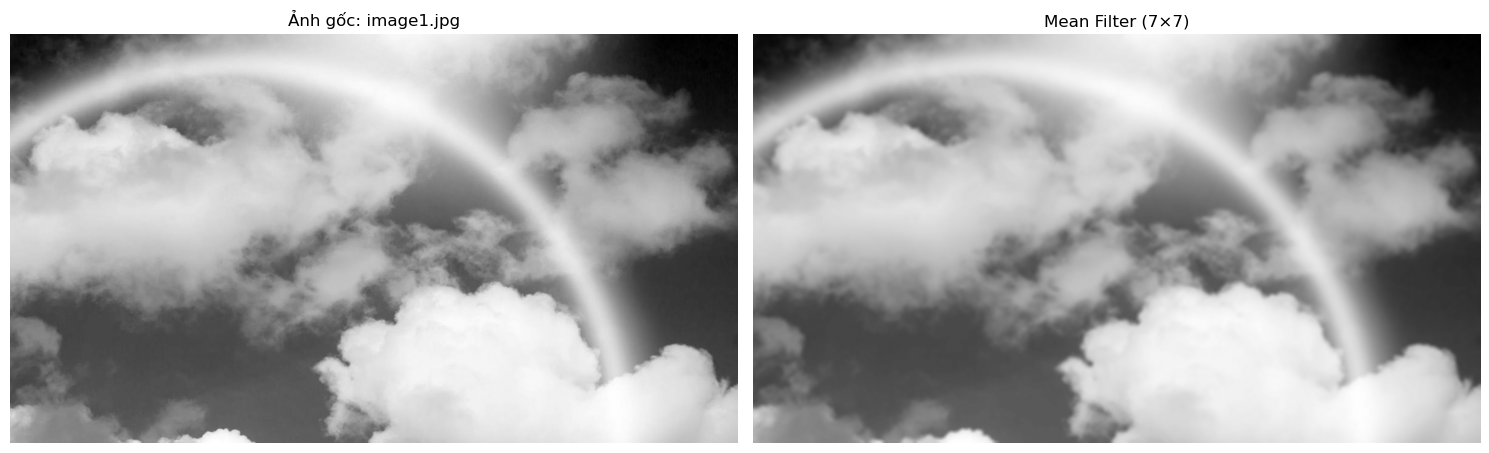

  Mean intensity - Original: 183.96
  Mean intensity - After Mean filter: 183.96

Đang hiển thị ảnh: image2.jpg


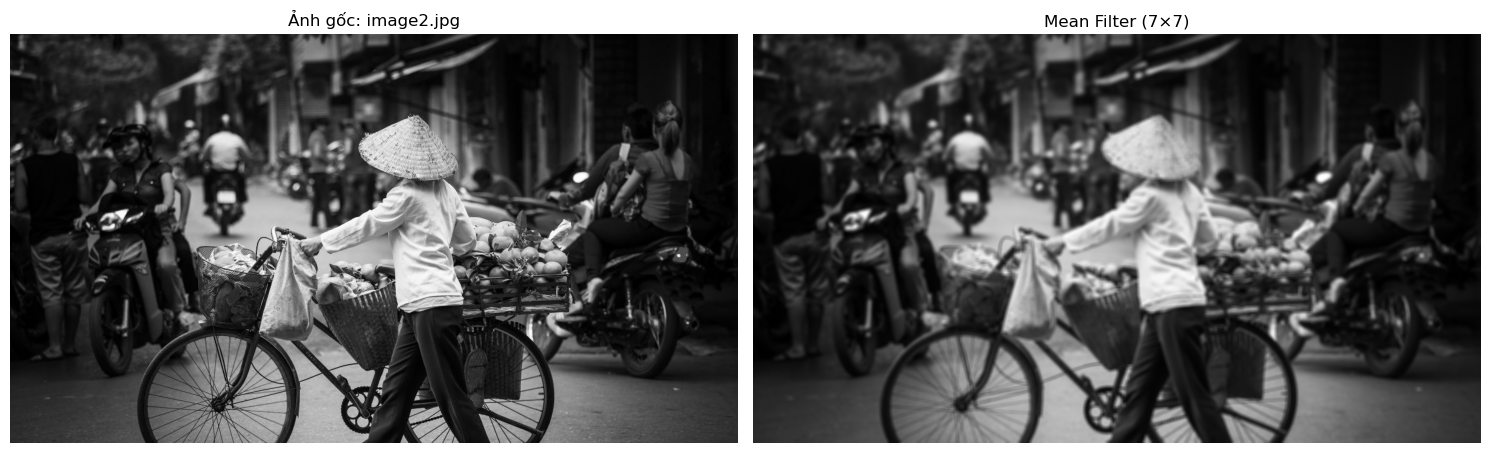

  Mean intensity - Original: 64.24
  Mean intensity - After Mean filter: 64.24


In [11]:
for path in image_paths:
    if not os.path.exists(path):
        continue
    
    # Đọc ảnh grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        continue
    
    print(f"\nĐang hiển thị ảnh: {path}")
    
    # Apply Mean Filter (Low-pass)
    mean_blur = cv2.blur(img, (7, 7))
    
    # Chuẩn bị dữ liệu hiển thị
    images = [img, mean_blur]
    titles = [f"Ảnh gốc: {path}", "Mean Filter (7×7)"]
    cmaps = ['gray', 'gray']
    
    # Hiển thị
    show_group(titles, images, cmaps)
    
    print(f"  Mean intensity - Original: {img.mean():.2f}")
    print(f"  Mean intensity - After Mean filter: {mean_blur.mean():.2f}")

### 2. Low-pass Filter: Gaussian Filter

**Mục đích:** Làm trơn ảnh với weighted averaging, preserve edges tốt hơn Mean filter. Chuẩn bị dữ liệu cho HIGH-PASS filtering.

**Công thức Kernel:** Trọng số của kernel tuân theo phân phối chuẩn (Gaussian Distribution). Với kernel $k \times k$, giá trị tại $(x,y)$ là:

$$G(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

**Cơ chế:** Weight giảm dần từ center. Pixel ở trung tâm có trọng số cao nhất, pixels xa có trọng số thấp → Preserve edges tốt hơn.


Đang hiển thị ảnh: image1.jpg


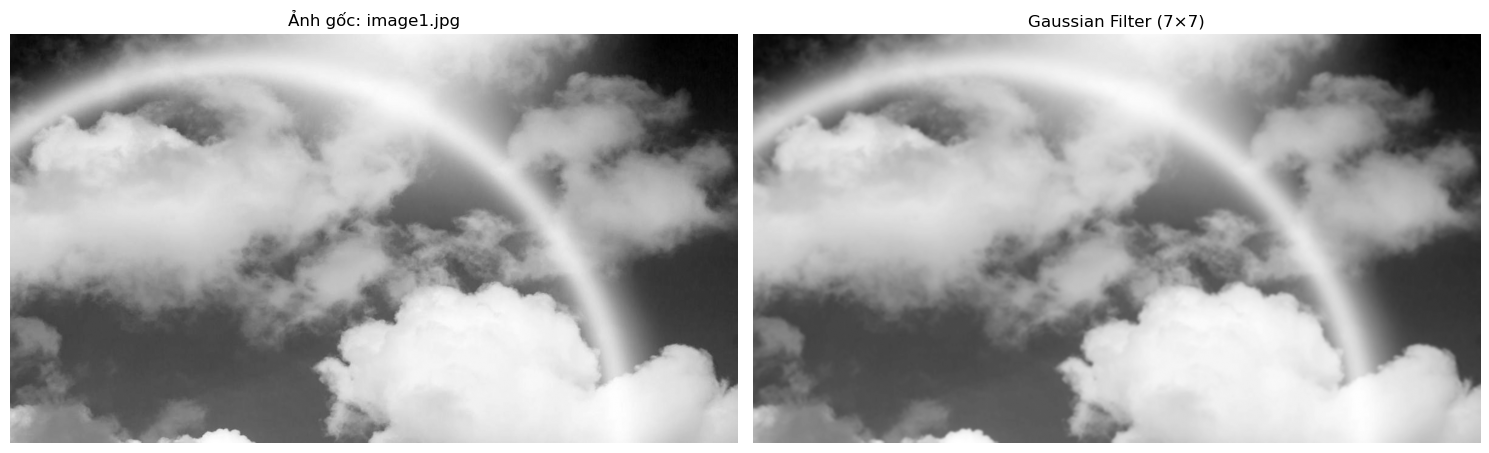

  Mean intensity - Original: 183.96
  Mean intensity - After Gaussian filter: 183.96

Đang hiển thị ảnh: image2.jpg


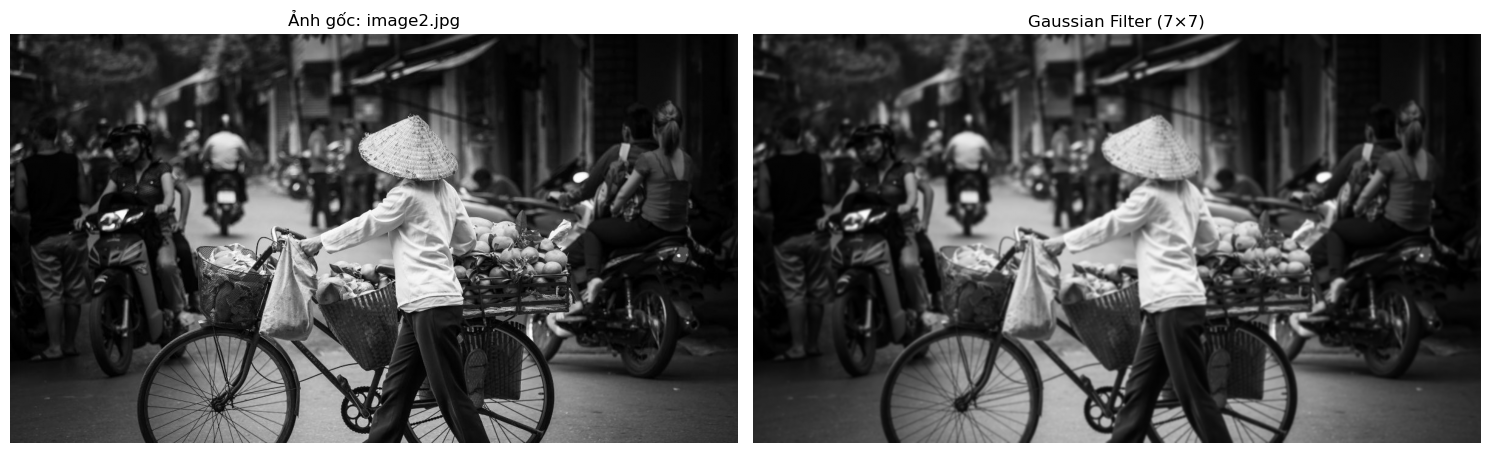

  Mean intensity - Original: 64.24
  Mean intensity - After Gaussian filter: 64.24

Đã chuẩn bị xong dữ liệu cho 2 ảnh.


In [13]:
data_storage = []

for path in image_paths:
    if not os.path.exists(path):
        continue
    
    # Đọc ảnh gốc
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        continue
    
    print(f"\nĐang hiển thị ảnh: {path}")
    
    # Tạo bản mượt (Gaussian Blur) để dùng cho so sánh sau này
    # Kernel (7,7) giúp loại bỏ nhiễu hạt hiệu quả
    img_blur = cv2.GaussianBlur(img, (7, 7), 0)
    
    # Lưu vào storage cho HIGH-PASS
    data_storage.append({
        'name': path,
        'original': img,
        'blur': img_blur
    })
    
    # Chuẩn bị dữ liệu hiển thị
    images = [img, img_blur]
    titles = [f"Ảnh gốc: {path}", "Gaussian Filter (7×7)"]
    cmaps = ['gray', 'gray']
    
    # Hiển thị
    show_group(titles, images, cmaps)
    
    print(f"  Mean intensity - Original: {img.mean():.2f}")
    print(f"  Mean intensity - After Gaussian filter: {img_blur.mean():.2f}")

print(f"\nĐã chuẩn bị xong dữ liệu cho {len(data_storage)} ảnh.")

# High-Pass Filter sử dụng kernel Laplacian và Sobel

### 1. High-pass Filter: Laplacian
**Mục đích:** Trích xuất biên dựa trên đạo hàm bậc 2. Nó cực kỳ nhạy cảm với các điểm thay đổi nhanh về độ sáng (cả biên và nhiễu).

**Ma trận Kernel (3x3):**
$$K_{Laplacian} = \begin{bmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{bmatrix}$$

* **Cơ chế:** Tổng các hệ số bằng 0. Nếu vùng ảnh có màu đồng nhất, kết quả tích chập sẽ bằng 0 (màu đen). Nếu có sự thay đổi, kết quả sẽ khác 0 (hiện biên).

--- PHÂN TÍCH: LAPLACIAN FILTER ---

Đang hiển thị ảnh: image1.jpg


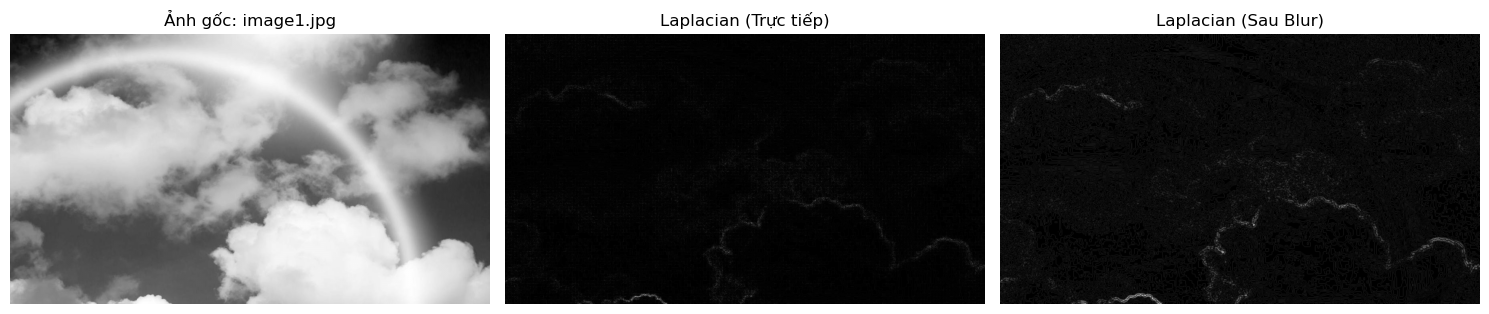


Đang hiển thị ảnh: image2.jpg


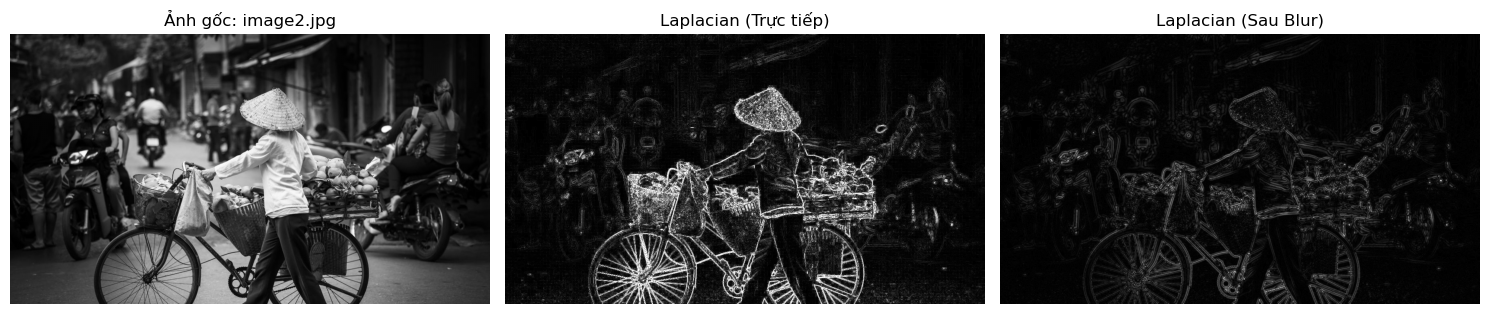

In [14]:
print("--- PHÂN TÍCH: LAPLACIAN FILTER ---")

for item in data_storage:
    print(f"\nĐang hiển thị ảnh: {item['name']}")
    
    img_org = item['original']
    img_blur = item['blur']

    # Tính Laplacian (High-pass)
    # Lưu ý: Dùng CV_64F để giữ biên âm, sau đó convertScaleAbs
    lap_raw = cv2.convertScaleAbs(cv2.Laplacian(img_org, cv2.CV_64F, ksize=3))
    lap_clean = cv2.convertScaleAbs(cv2.Laplacian(img_blur, cv2.CV_64F, ksize=3))

    # Chuẩn bị dữ liệu hiển thị
    images = [img_org, lap_raw, lap_clean]
    titles = [f"Ảnh gốc: {item['name']}", "Laplacian (Trực tiếp)", "Laplacian (Sau Blur)"]
    cmaps = ['gray', 'gray', 'gray']

    # Gọi hàm hiển thị
    show_group(titles, images, cmaps)

### 2. High-pass Filter: Sobel Operator
**Mục đích:** Trích xuất biên theo hướng cụ thể bằng đạo hàm bậc 1.

**a. Sobel X (Biên dọc):**
Phát hiện sự thay đổi cường độ theo chiều ngang (trái sang phải).
$$K_{SobelX} = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

**b. Sobel Y (Biên ngang):**
Phát hiện sự thay đổi cường độ theo chiều dọc (trên xuống dưới).
$$K_{SobelY} = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}$$

--- PHÂN TÍCH: SOBEL THEO HƯỚNG (X & Y) ---

Đang hiển thị ảnh: image1.jpg


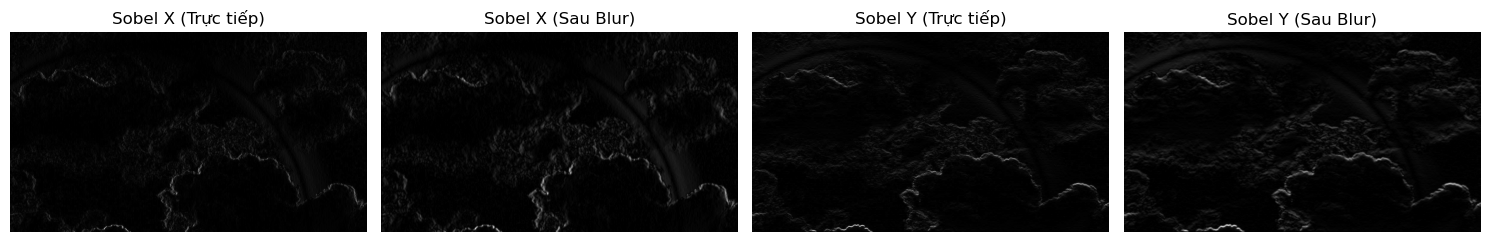


Đang hiển thị ảnh: image2.jpg


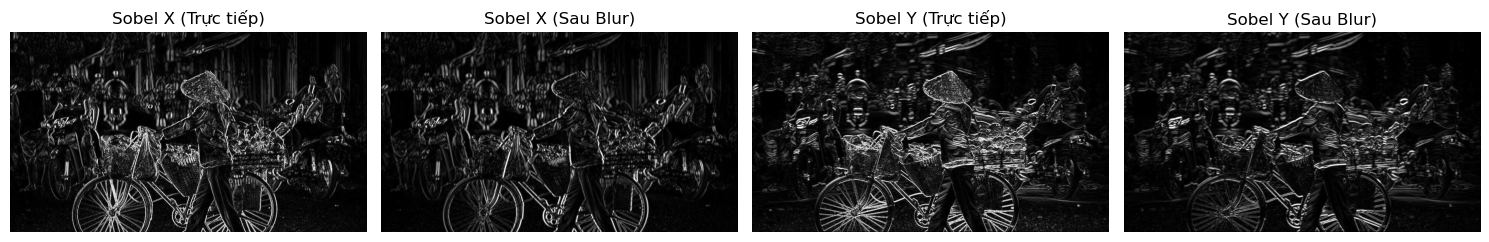

In [15]:
print("--- PHÂN TÍCH: SOBEL THEO HƯỚNG (X & Y) ---")

for item in data_storage:
    print(f"\nĐang hiển thị ảnh: {item['name']}")
    
    img_org = item['original']
    img_blur = item['blur']

    # Tính Sobel X (Biên dọc)
    sx_raw = cv2.convertScaleAbs(cv2.Sobel(img_org, cv2.CV_64F, 1, 0, ksize=3))
    sx_clean = cv2.convertScaleAbs(cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=3))

    # Tính Sobel Y (Biên ngang)
    sy_raw = cv2.convertScaleAbs(cv2.Sobel(img_org, cv2.CV_64F, 0, 1, ksize=3))
    sy_clean = cv2.convertScaleAbs(cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=3))

    # Hiển thị 4 ảnh trên 1 hàng
    images = [sx_raw, sx_clean, sy_raw, sy_clean]
    titles = ["Sobel X (Trực tiếp)", "Sobel X (Sau Blur)", "Sobel Y (Trực tiếp)", "Sobel Y (Sau Blur)"]
    cmaps = ['gray'] * 4

    show_group(titles, images, cmaps)

### 3. Kết hợp Sobel (Magnitude)
**Mục đích:** Tạo ra một bản đồ biên hoàn chỉnh, bao gồm cả các đường thẳng đứng và nằm ngang.

**Công thức:**
Để tối ưu tốc độ tính toán (tránh phép khai căn $\sqrt{G_x^2 + G_y^2}$), trong đoạn code này chúng ta sử dụng công thức xấp xỉ có trọng số (Weighted Sum):

$$G_{final} \approx 0.5 \cdot |Sobel_X| + 0.5 \cdot |Sobel_Y|$$


--- PHÂN TÍCH: SOBEL TỔNG HỢP (MAGNITUDE) ---

Đang hiển thị ảnh: image1.jpg


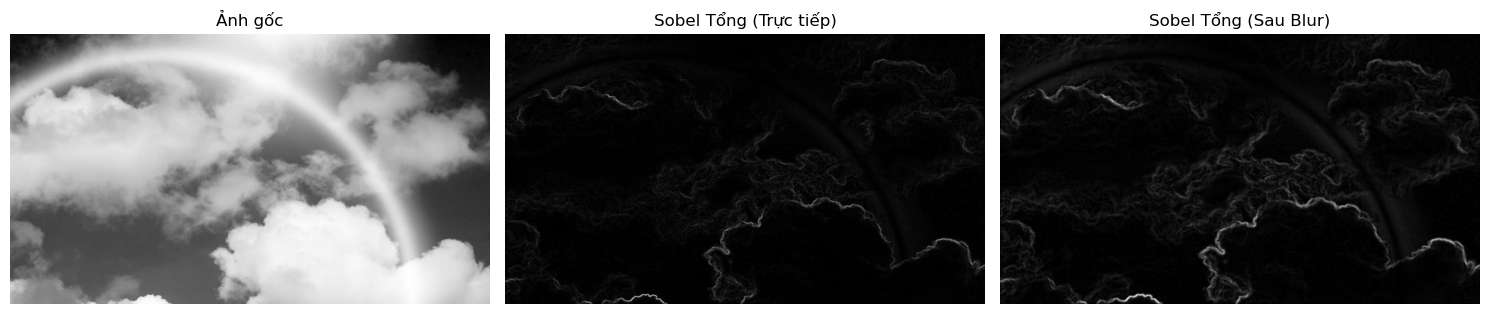


Đang hiển thị ảnh: image2.jpg


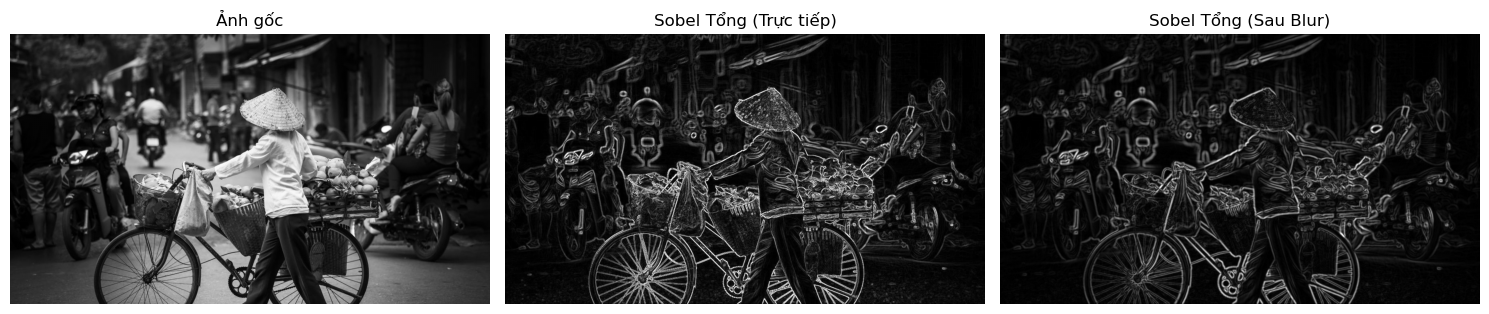

In [16]:
print("--- PHÂN TÍCH: SOBEL TỔNG HỢP (MAGNITUDE) ---")

def get_combined_sobel(src):
    """Hàm phụ trợ tính Sobel tổng hợp"""
    sx = cv2.convertScaleAbs(cv2.Sobel(src, cv2.CV_64F, 1, 0, ksize=3))
    sy = cv2.convertScaleAbs(cv2.Sobel(src, cv2.CV_64F, 0, 1, ksize=3))
    # Công thức: 0.5*|X| + 0.5*|Y|
    return cv2.addWeighted(sx, 0.5, sy, 0.5, 0)

for item in data_storage:
    print(f"\nĐang hiển thị ảnh: {item['name']}")
    
    img_org = item['original']
    img_blur = item['blur']

    # Tính toán
    comb_raw = get_combined_sobel(img_org)
    comb_clean = get_combined_sobel(img_blur)

    # Hiển thị
    images = [img_org, comb_raw, comb_clean]
    titles = [f"Ảnh gốc", "Sobel Tổng (Trực tiếp)", "Sobel Tổng (Sau Blur)"]
    cmaps = ['gray', 'gray', 'gray']

    show_group(titles, images, cmaps)